In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

In [4]:
class DCGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(DCGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(DCGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = ConvBlock(16)(inputs)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1)(x)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [8]:
gan = DCGAN(train_X.shape[1:], 100)

In [9]:
gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

In [10]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6154 - g_loss: 0.8716

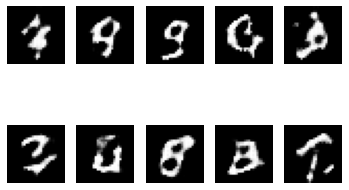

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6154 - g_loss: 0.8714
Epoch 2/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6388 - g_loss: 0.8238
Epoch 3/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6584 - g_loss: 0.7938
Epoch 4/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6640 - g_loss: 0.7850
Epoch 5/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6602 - g_loss: 0.7902
Epoch 6/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6612 - g_loss: 0.7880
Epoch 7/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6629 - g_loss: 0.7875
Epoch 8/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6656 - g_loss: 0.7824
Epoch 9/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6675 - g_loss: 0.7814
Epoch 10/101
1875/1875 [==============================] - 26s 14ms/

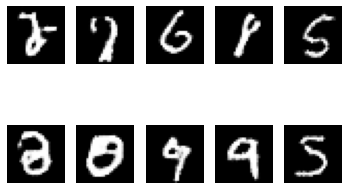

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6729 - g_loss: 0.7739
Epoch 12/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6742 - g_loss: 0.7692
Epoch 13/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6755 - g_loss: 0.7651
Epoch 14/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6767 - g_loss: 0.7613
Epoch 15/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6778 - g_loss: 0.7609
Epoch 16/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6785 - g_loss: 0.7571
Epoch 17/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6794 - g_loss: 0.7562
Epoch 18/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6795 - g_loss: 0.75460s - d_loss: 0.679
Epoch 19/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6799 - g_loss: 0.7518
Epoch 20/101
1875/1875 [=================

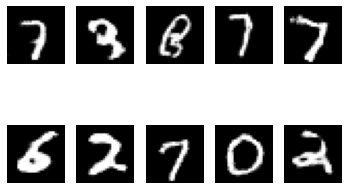

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6810 - g_loss: 0.7479
Epoch 22/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6807 - g_loss: 0.7486
Epoch 23/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6815 - g_loss: 0.7473
Epoch 24/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6821 - g_loss: 0.7447
Epoch 25/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6823 - g_loss: 0.7448
Epoch 26/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7442
Epoch 27/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6823 - g_loss: 0.7426
Epoch 28/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7424
Epoch 29/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6830 - g_loss: 0.7403
Epoch 30/101
1875/1875 [==============================] - 2

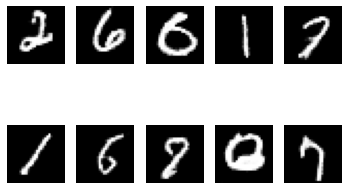

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6831 - g_loss: 0.7399
Epoch 32/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7401
Epoch 33/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6832 - g_loss: 0.7385
Epoch 34/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6828 - g_loss: 0.7390
Epoch 35/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6834 - g_loss: 0.7385
Epoch 36/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6832 - g_loss: 0.7392
Epoch 37/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6824 - g_loss: 0.7398
Epoch 38/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6823 - g_loss: 0.7395
Epoch 39/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7398
Epoch 40/101
1875/1875 [==============================] - 2

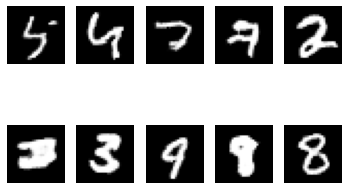

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7396
Epoch 42/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7398
Epoch 43/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7397
Epoch 44/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6825 - g_loss: 0.7400
Epoch 45/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6827 - g_loss: 0.7392
Epoch 46/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6831 - g_loss: 0.7375
Epoch 47/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7404
Epoch 48/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6829 - g_loss: 0.7388
Epoch 49/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6829 - g_loss: 0.7396
Epoch 50/101
1875/1875 [==============================] - 2

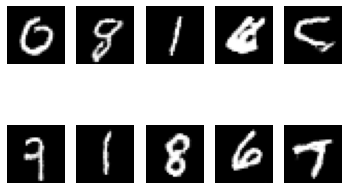

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6835 - g_loss: 0.7375
Epoch 52/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6828 - g_loss: 0.7395
Epoch 53/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7400
Epoch 54/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6833 - g_loss: 0.7389
Epoch 55/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.73950s - d_loss: 0.6
Epoch 56/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6830 - g_loss: 0.7391
Epoch 57/101
1875/1875 [==============================] - 27s 15ms/step - d_loss: 0.6831 - g_loss: 0.7395
Epoch 58/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6830 - g_loss: 0.7393
Epoch 59/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6830 - g_loss: 0.7388
Epoch 60/101
1875/1875 [===================

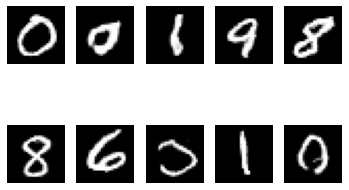

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6830 - g_loss: 0.7388
Epoch 62/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6828 - g_loss: 0.7401
Epoch 63/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7402
Epoch 64/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6832 - g_loss: 0.7388
Epoch 65/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6828 - g_loss: 0.7394
Epoch 66/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6829 - g_loss: 0.7398
Epoch 67/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6829 - g_loss: 0.7395
Epoch 68/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6830 - g_loss: 0.7392
Epoch 69/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6832 - g_loss: 0.7392
Epoch 70/101
1875/1875 [==============================] - 2

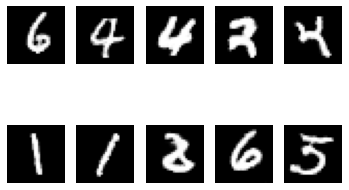

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6829 - g_loss: 0.7401
Epoch 72/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7396
Epoch 73/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6822 - g_loss: 0.7417
Epoch 74/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6823 - g_loss: 0.7404
Epoch 75/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7401
Epoch 76/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7410
Epoch 77/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6832 - g_loss: 0.7393
Epoch 78/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6829 - g_loss: 0.7398
Epoch 79/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6828 - g_loss: 0.7400
Epoch 80/101
1875/1875 [==============================] - 2

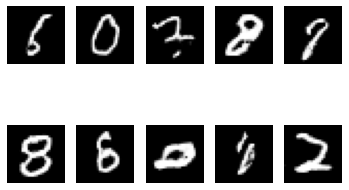

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6823 - g_loss: 0.7418
Epoch 82/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6828 - g_loss: 0.7404
Epoch 83/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6827 - g_loss: 0.7402
Epoch 84/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6825 - g_loss: 0.7406
Epoch 85/101
1875/1875 [==============================] - 27s 15ms/step - d_loss: 0.6822 - g_loss: 0.7409
Epoch 86/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6824 - g_loss: 0.7415
Epoch 87/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6824 - g_loss: 0.7412
Epoch 88/101
1875/1875 [==============================] - 33s 18ms/step - d_loss: 0.6827 - g_loss: 0.7408
Epoch 89/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6824 - g_loss: 0.7415
Epoch 90/101
1875/1875 [==============================] - 2

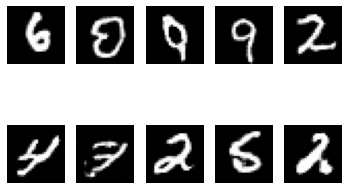

1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6831 - g_loss: 0.7404
Epoch 92/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6824 - g_loss: 0.7416
Epoch 93/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6824 - g_loss: 0.7413
Epoch 94/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6820 - g_loss: 0.7418
Epoch 95/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7415
Epoch 96/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6821 - g_loss: 0.7423
Epoch 97/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7411
Epoch 98/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7414
Epoch 99/101
1875/1875 [==============================] - 27s 14ms/step - d_loss: 0.6822 - g_loss: 0.7420
Epoch 100/101
1875/1875 [==============================] - 

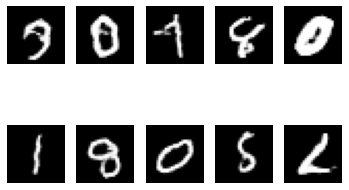

1875/1875 [==============================] - 30s 16ms/step - d_loss: 0.6819 - g_loss: 0.7428


In [11]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=32)